# LICS Evaluation 
Evaluate different segmentation approaches on the LICS test dataset. These include the deterministic superpixel algorithm, pretrained and finetuned U-Net model. The accuracy, precision, recall, F1 and FOM metrics are calculated. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import train
import network
import torch

import glob

import importlib
import evaluation as eval
import utils
importlib.reload(utils)
importlib.reload(eval)

base_path = '../../data/'

/Users/conorosullivan/Documents/git/COASTAL MONITORING/superpixel-annotation/venv_sp/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# LICS

In [3]:
# Model names
lics_original = "LICS_UNET_12JUL2024.pth" #Previous SOTA approach (model from original LICS paper)
# Note reuslts will be slightly differnet than LICS paper due to random seed
lics_superpixel = "LICS_SUPERPIXELS_26JUL2024.pth" #Pretrained model trained on superpixel output
lics_finetune = "LICS_FINETUNE_26JUL24.pth" #Fine-tuned model 

In [4]:
# Load LICS data
incl_bands = [0,1,2,3,4,5,6]
satellite = 'landsat'

# Test data
target_pos = -2

lics_test_file = base_path + 'LICS/test/'
lics_test_paths = glob.glob(lics_test_file + '*.npy')
lics_test_targets = [np.load(file)[:,:,target_pos] for file in lics_test_paths]
lics_test_input = [np.load(file)[:,:,incl_bands] for file in lics_test_paths]

print("Test dimensions:")
print(np.shape(lics_test_targets))
print(np.shape(lics_test_input))

# Finetune data
target_pos = -1

lics_finetune_file = base_path + 'LICS/finetune/'
lics_finetune_paths = glob.glob(lics_finetune_file + '*.npy')
lics_finetune_targets = [np.load(file)[:,:,target_pos] for file in lics_finetune_paths]
lics_finetune_input = [np.load(file)[:,:,incl_bands] for file in lics_finetune_paths]

print("\nFinetune dimensions:")
print(np.shape(lics_finetune_targets))
print(np.shape(lics_finetune_input))

Test dimensions:
(100, 256, 256)
(100, 256, 256, 7)

Finetune dimensions:
(100, 256, 256)
(100, 256, 256, 7)


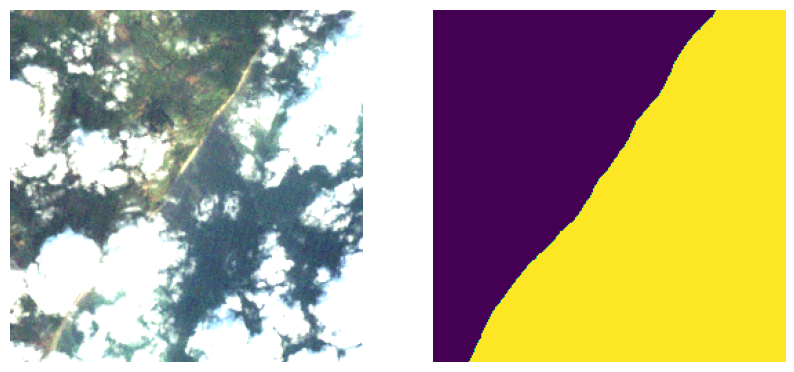

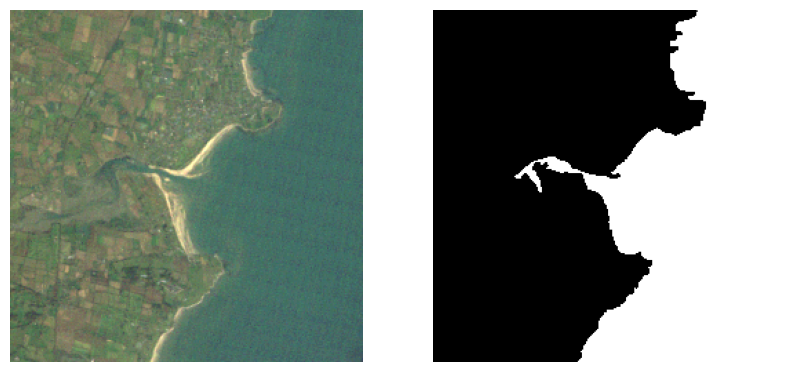

In [143]:
# Sense check the data

# Test data
i = np.random.randint(0,len(lics_test_paths))
rgb = utils.get_rgb(lics_test_input[i],satellite=satellite,contrast=0.2)
target = lics_test_targets[i]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rgb)
ax[1].imshow(target)

for a in ax:
    a.axis('off')

# Finetune data
i = np.random.randint(0,len(lics_finetune_paths))
rgb = utils.get_rgb(lics_finetune_input[i],satellite=satellite,contrast=0.2)
target = lics_finetune_targets[i]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rgb)
ax[1].imshow(target, cmap='gray')

for a in ax:
    a.axis('off')

## Superpixel algorithm

In [144]:
# Ititialize metrics
lics_test_metrics = {}
lics_finetune_metrics = {}

In [145]:
def get_sp_predictions(paths,satellite,rgb_bands,index_name,threshold = -1,method='slic', **kwargs):
    # Copy the input image to avoid modifying the original
    preds = []
    for path in paths:
        all_bands = np.load(path)
        mask = utils.get_mask_from_bands(all_bands, 
                                         satellite=satellite,
                                         rgb_bands=rgb_bands,
                                         threshold=threshold, 
                                         index_name=index_name,
                                         method=method, **kwargs)
        preds.append(mask)
    return preds


accuracy: 96.6205
balanced_accuracy: 97.0476
precision: 94.653
recall: 98.2458
f1: 96.0356
mse: 2.4675
fom: 70.1573


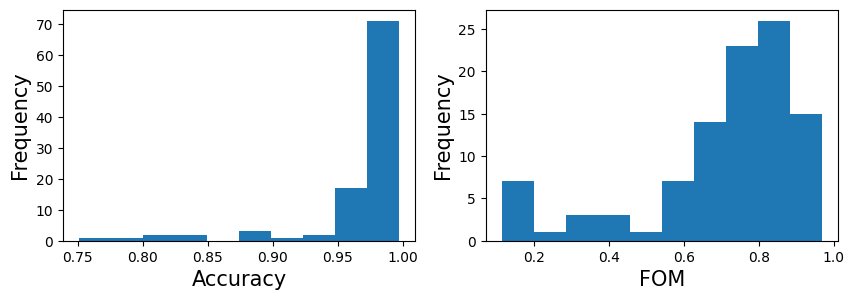

In [146]:
# Test
preds_sp = get_sp_predictions(lics_test_paths,
                           satellite='landsat',
                           rgb_bands=["nir", "green", "blue"],
                           index_name="NDWI",
                           threshold=-1, 
                           method='felzenszwalb',
                           min_size=60)

metrics, arr = eval.eval_metrics(lics_test_targets,preds_sp)
lics_test_metrics['superpixels'] = metrics
eval.display_metrics(metrics,arr)

accuracy: 97.2043
balanced_accuracy: 97.5622
precision: 95.6251
recall: 99.0015
f1: 96.866
mse: 2.3038
fom: 72.6957


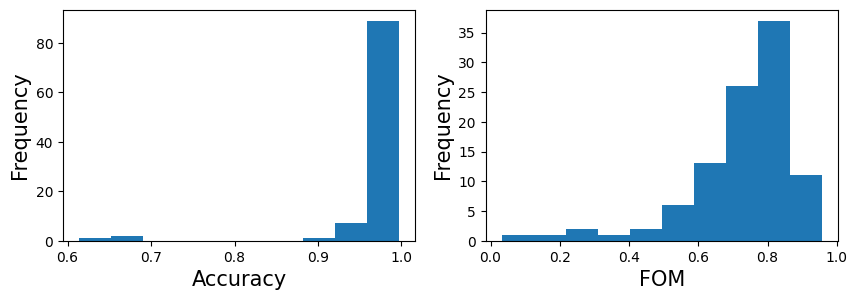

In [9]:
# Finetune
preds = get_sp_predictions(lics_finetune_paths,
                            satellite='landsat',
                            rgb_bands=["nir", "green", "blue"],
                            index_name="NDWI",
                            threshold=-1, 
                            method='felzenszwalb',
                            min_size=60)

metrics, arr = eval.eval_metrics(lics_finetune_targets,preds)
lics_finetune_metrics['superpixels'] = metrics
eval.display_metrics(metrics,arr)

# Original model

In [147]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = network.U_Net(7,2).to(device)

# Load saved model 
#model = torch.load('../models/LANDSAT-UNET-20JUL23.pth', map_location=torch.device('cpu') )
state_dict = torch.load(f'../../models/{lics_original}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

100
accuracy: 95.2733
balanced_accuracy: 95.5799
precision: 94.7017
recall: 94.681
f1: 94.1968
mse: 3.179
fom: 55.8655


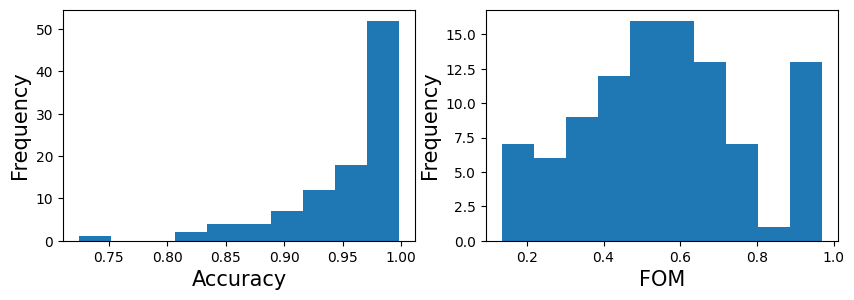

In [11]:
# Test
targets, preds = eval.get_preds(model,lics_test_paths,target_pos=-2,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(lics_test_targets ,preds)
lics_test_metrics['original'] = metrics
eval.display_metrics(metrics,arr)

100
accuracy: 96.6381
balanced_accuracy: 96.9586
precision: 96.4065
recall: 96.4229
f1: 95.9464
mse: 2.4541
fom: 62.0902


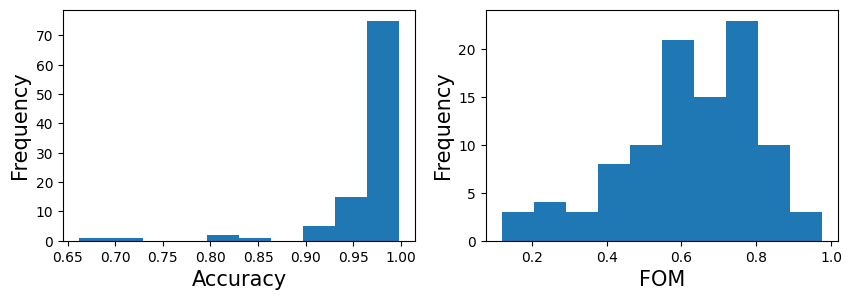

In [12]:
# Finetune
targets, preds = eval.get_preds(model,lics_finetune_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(lics_finetune_targets ,preds)
lics_finetune_metrics['original'] = metrics
eval.display_metrics(metrics,arr)

## Rough model

In [148]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = network.U_Net(7,2).to(device)

# Load saved model 
#model = torch.load('../models/LANDSAT-UNET-20JUL23.pth', map_location=torch.device('cpu') )
state_dict = torch.load(f'../../models/{lics_superpixel}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

100
accuracy: 96.292
balanced_accuracy: 96.7244
precision: 93.6355
recall: 98.4943
f1: 95.7358
mse: 2.8651
fom: 68.8882


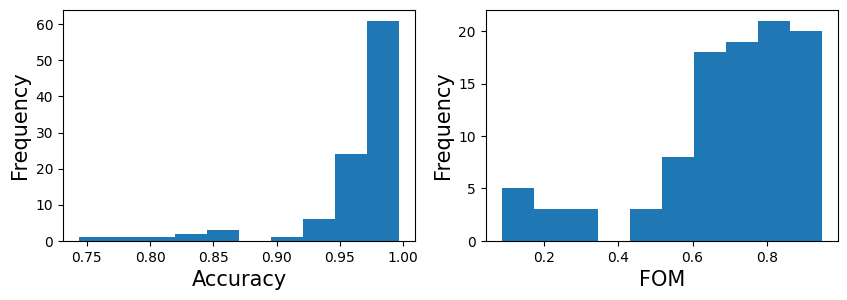

In [149]:
# Test
targets, preds_pretrained = eval.get_preds(model,lics_test_paths,target_pos=-2,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(lics_test_targets ,preds_pretrained)
lics_test_metrics['rough_model'] = metrics
eval.display_metrics(metrics,arr)

100
accuracy: 96.959
balanced_accuracy: 97.4114
precision: 94.873
recall: 98.9813
f1: 96.4331
mse: 2.5489
fom: 71.1011


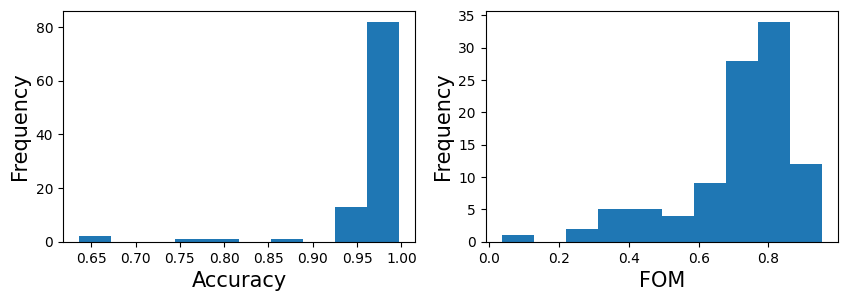

In [15]:
# Finetune
targets, preds = eval.get_preds(model,lics_finetune_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(lics_finetune_targets ,preds)
lics_finetune_metrics['rough_model'] = metrics
eval.display_metrics(metrics,arr)


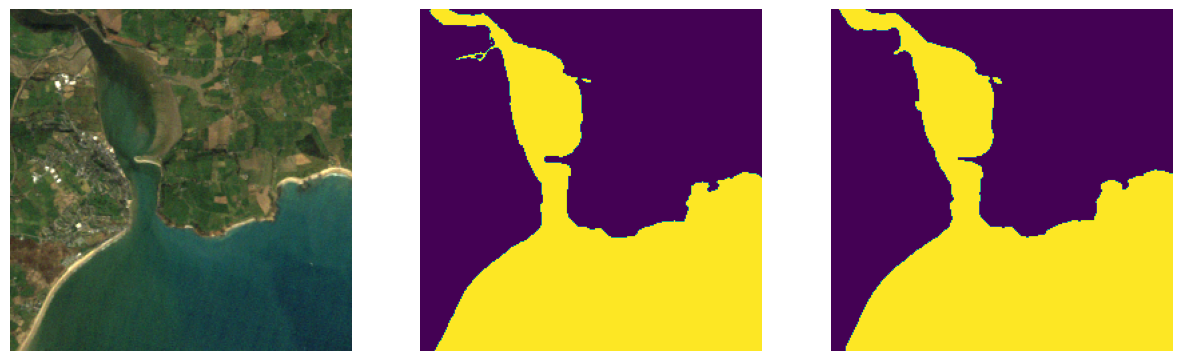

In [42]:
# Display some predictions
i = np.random.randint(0,len(lics_test_paths))
rgb = utils.get_rgb(lics_test_input[i],satellite=satellite,contrast=0.2)
target = lics_test_targets[i]
pred = preds[i]

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

# Finetuned model

In [150]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = network.U_Net(7,2).to(device)

# Load saved model 
#model = torch.load('../models/LANDSAT-UNET-20JUL23.pth', map_location=torch.device('cpu') )
state_dict = torch.load(f'../../models/{lics_finetune}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

100
accuracy: 98.5499
balanced_accuracy: 98.3517
precision: 99.2291
recall: 97.3227
f1: 98.2106
mse: 1.7592
fom: 80.1804


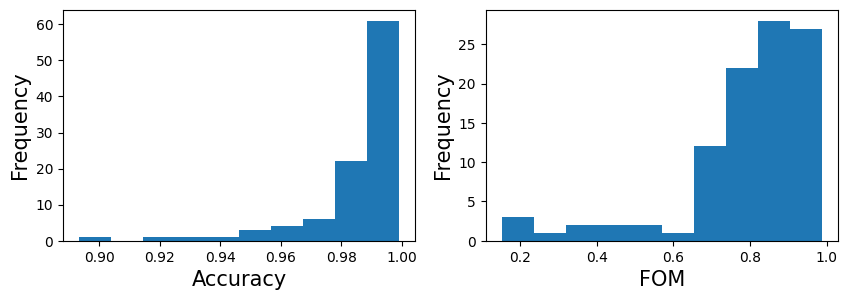

In [151]:
# Test
targets, preds_finetuned = eval.get_preds(model,lics_test_paths,target_pos=-2,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(lics_test_targets ,preds_finetuned)
lics_test_metrics['finetune_model'] = metrics
eval.display_metrics(metrics,arr)

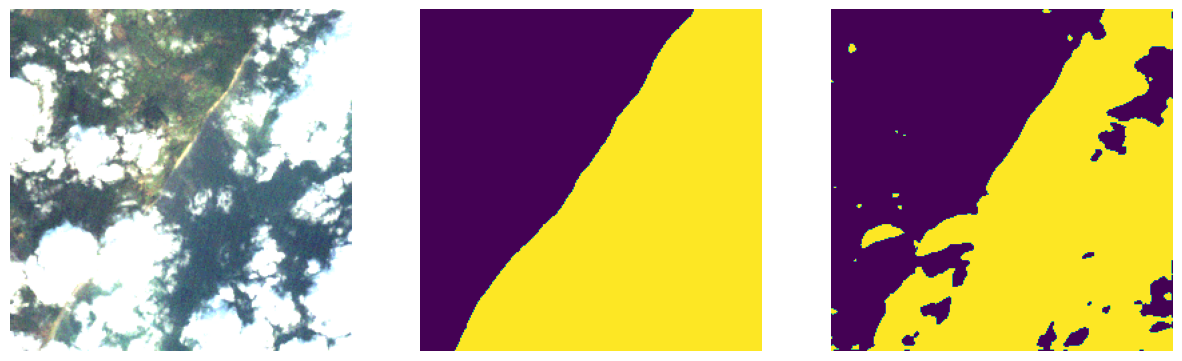

In [18]:
# Display some predictions
i = np.random.randint(0,len(lics_test_paths))
rgb = utils.get_rgb(lics_test_input[i],satellite=satellite,contrast=0.2)
target = lics_test_targets[i]
pred = preds[i]

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

100
accuracy: 99.0255
balanced_accuracy: 98.952
precision: 98.9313
recall: 98.8405
f1: 98.864
mse: 1.3326
fom: 82.3781


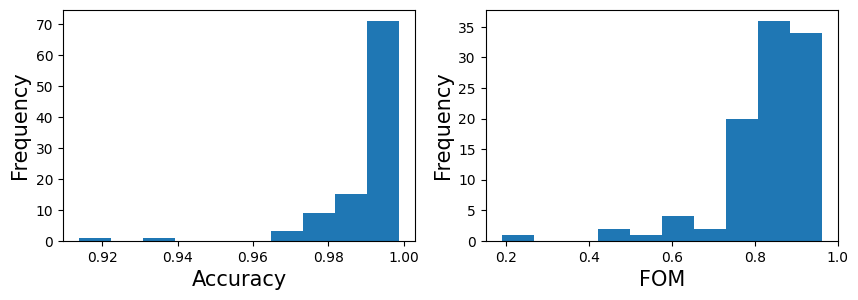

In [19]:
# Finetune
targets, preds = eval.get_preds(model,lics_finetune_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(lics_finetune_targets ,preds)
lics_finetune_metrics['finetune_model'] = metrics
eval.display_metrics(metrics,arr)

# Final Metrics Table

In [24]:
import json

# Save metrics
with open('lics_test_metrics.json', 'w') as f:
    json.dump(lics_test_metrics, f)

with open('lics_finetune_metrics.json', 'w') as f:
    json.dump(lics_finetune_metrics, f)

In [22]:
# Test metrics
df_test_metrics = pd.read_csv('lics_test_metrics.csv')
df_test_metrics

,Unnamed: 0,superpixels,original,rough_model,finetune_model
0,accuracy,0.966205,0.952733,0.962920,0.985499
1,balanced_accuracy,0.970476,0.955799,0.967244,0.983517
2,precision,0.946530,0.947017,0.936355,0.992291
3,recall,0.982458,0.946810,0.984943,0.973227
4,f1,0.960356,0.941968,0.957358,0.982106
5,mse,0.024675,0.031790,0.028651,0.017592
6,fom,0.701573,0.558655,0.688882,0.801804


In [25]:
df_test_metrics = json.load(open('lics_test_metrics.json'))
df_test_metrics = pd.DataFrame(df_test_metrics)

df_test_metrics = df_test_metrics[['original','superpixels','rough_model','finetune_model']]
df_test_metrics = df_test_metrics.transpose()
df_test_metrics = df_test_metrics[['accuracy','precision','recall','f1','fom']]
np.round(df_test_metrics,3)

,accuracy,precision,recall,f1,fom
original,0.953,0.947,0.947,0.942,0.559
superpixels,0.966,0.947,0.982,0.960,0.702
rough_model,0.963,0.936,0.985,0.957,0.689
finetune_model,0.985,0.992,0.973,0.982,0.802


In [26]:
# Finetune metrics
df_finetune_metrics = json.load(open('lics_finetune_metrics.json'))
df_finetune_metrics = pd.DataFrame(df_finetune_metrics)

df_finetune_metrics = df_finetune_metrics[['original','superpixels','rough_model','finetune_model']]
df_finetune_metrics = df_finetune_metrics.transpose()
df_finetune_metrics = df_finetune_metrics[['accuracy','precision','recall','f1','fom']]

np.round(df_finetune_metrics,3)

,accuracy,precision,recall,f1,fom
original,0.966,0.964,0.964,0.959,0.621
superpixels,0.972,0.956,0.990,0.969,0.727
rough_model,0.970,0.949,0.990,0.964,0.711
finetune_model,0.990,0.989,0.988,0.989,0.824


In [33]:
accuracy = df_finetune_metrics[['accuracy']]
accuracy['Test'] = df_test_metrics[['accuracy']]
accuracy.columns = ['Finetune','Test']
round(accuracy,3)

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_43422/3607479064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy['Test'] = df_test_metrics[['accuracy']]


,Finetune,Test
original,0.966,0.953
superpixels,0.972,0.966
rough_model,0.970,0.963
finetune_model,0.990,0.985


# Visualisations

84


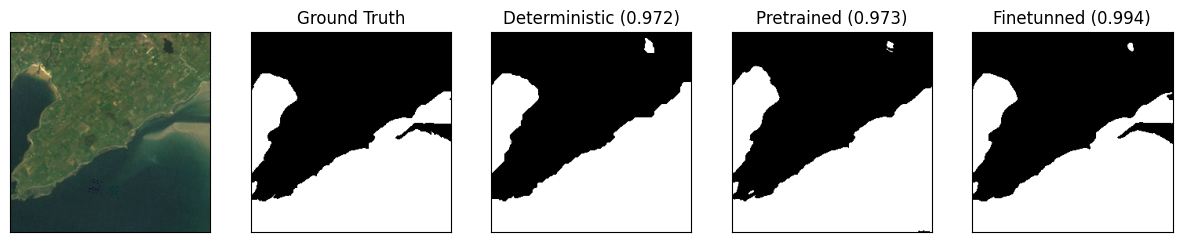

In [160]:
# Display some predictions
i = 84
print(i)
rgb = utils.get_rgb(lics_test_input[i],satellite=satellite,contrast=0.2)
target = lics_test_targets[i]

fig, ax = plt.subplots(1,5,figsize=(15,5))
ax[0].imshow(rgb)
ax[1].imshow(target, cmap='gray')
ax[1].set_title("Ground Truth")

ax[2].imshow(preds_sp[i], cmap='gray')
accuracy = np.sum(preds_sp[i] == target) / np.size(target)
ax[2].set_title("Deterministic ({:.3f})".format(accuracy))

ax[3].imshow(preds_pretrained[i], cmap='gray')
accuracy = np.sum(preds_pretrained[i] == target) / np.size(target)
ax[3].set_title("Pretrained ({:.3f})".format(accuracy))

ax[4].imshow(preds_finetuned[i], cmap='gray')
accuracy = np.sum(preds_finetuned[i] == target) / np.size(target)
ax[4].set_title("Finetunned ({:.3f})".format(accuracy))

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

#utils.save_fig(fig, 'inland_water_bodies')

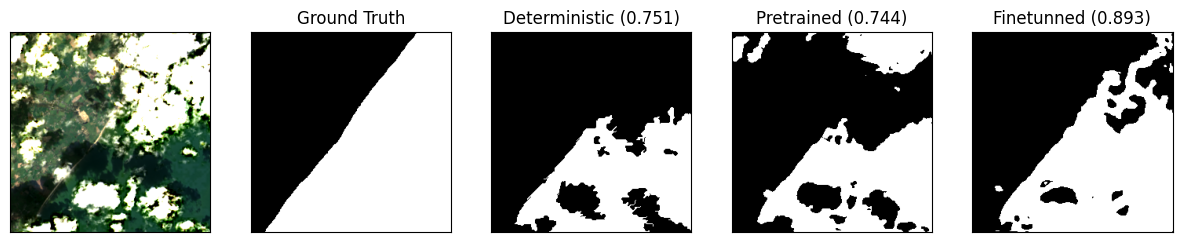

In [161]:
# Display some predictions
i = 16
rgb = utils.get_rgb(lics_test_input[i],satellite=satellite,contrast=0.2)
target = lics_test_targets[i]

fig, ax = plt.subplots(1,5,figsize=(15,5))
ax[0].imshow(rgb)
ax[1].imshow(target, cmap='gray')
ax[1].set_title("Ground Truth")

ax[2].imshow(preds_sp[i], cmap='gray')
accuracy = np.sum(preds_sp[i] == target) / np.size(target)
ax[2].set_title("Deterministic ({:.3f})".format(accuracy))

ax[3].imshow(preds_pretrained[i], cmap='gray')
accuracy = np.sum(preds_pretrained[i] == target) / np.size(target)
ax[3].set_title("Pretrained ({:.3f})".format(accuracy))

ax[4].imshow(preds_finetuned[i], cmap='gray')
accuracy = np.sum(preds_finetuned[i] == target) / np.size(target)
ax[4].set_title("Finetunned ({:.3f})".format(accuracy))

for a in ax:
    a.set_xticks([])
    a.set_yticks([])